# Import libraries

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cmx
from mpl_toolkits import mplot3d
import pandas as pd
from scipy.signal import hilbert
from scipy.integrate import cumtrapz
import os
import pickle
from pyfuncs import *

startdir = '/Users/leo/Desktop/ResearchPhD/PitchControl/analysis/'
%qtconsole

# Read in selected data, combine into one large dataframe

In [6]:
runDates = ['20210803_1','20210816','20210817_1','20210818_1']

# Load dataframes
os.chdir(os.path.join(startdir,'preprocessedCache'))
for i,d in enumerate(runDates):
    dtemp = pd.read_hdf(d+'.h5')
    dtemp['date'] =  d
    if i==0:
        df = dtemp
    else:
        df = df.append(dtemp)
# Load other relevant variables
file = open(os.path.join(startdir, 'preprocessedCache', 'vars')+'.pkl', 'rb')
translations, runDates = pickle.load(file)
file.close()

# Channel names to process
channelsEMG = ['LDVM', 'LDLM', 'RDLM', 'RDVM']
channelsFT = ['fx', 'fy', 'fz', 'mx', 'my', 'mz']


In [9]:
%matplotlib auto
fig, ax = plt.subplots(len(runDates), 3, sharex=True)
for i,d in enumerate(runDates):
    dt = df.loc[(df.date==d) & (df.pulse==1),].copy()
    for j,m in enumerate(channelsFT[3:]):
        for jj in np.unique(dt['wb']):
            ax[i,j].plot(dt.loc[dt['wb']==jj, 'phase'], dt.loc[dt['wb']==jj, m], alpha=0.6)


Using matplotlib backend: MacOSX


# Look for ways to split by upstroke and downstroke

Why not split upstroke and downstroke (or, at least, split the wingstroke into halves) by taking the other points where the hilbert transform angle flips across zero?

# Estimating "actual pitch" from pitch torque

I am slightly suspicious of this, partially because I don't trust that we've actually transformed FT matrix to be at the real COM, especially going from individual to individual. How much would that throw off this analysis? Do we have stronger ways to verify?

In [13]:
dt = df.loc[(df.date=='20210817_1') & (df.pulse==1),].copy()
dt.Time -= dt.Time.iloc[0]

fsamp = 10000
Iyy = 266.7/1000/(1000**2) # gmm^2 to kg m^2

plt.figure()
time = dt.Time.to_numpy()
mx = dt.mx
theta = cumtrapz(cumtrapz(mx/1000**2/Iyy, dx=1/fsamp), dx=1/fsamp)*180/np.pi
for j in np.unique(dt['wb']):
    if j % 2 == 0:
        wbtime = dt.loc[dt['wb']==j, 'Time'].to_numpy()
        plt.axvspan(wbtime[0], wbtime[-1], lw=0, color='#C2C2C2')
plt.plot(time, dt.mx)
ax1 = plt.gca()
ax2 = ax1.twinx()
ax2.plot(time[1:-1], theta)

# Phase-aligned vs. spike-aligned torque waveforms

Similar to Simon's 2015 PLS paper; compare waveform alignment when aligned by wingbeat phase (zero crossing of hilbert transform) vs when aligned by first spike timing of a given muscle

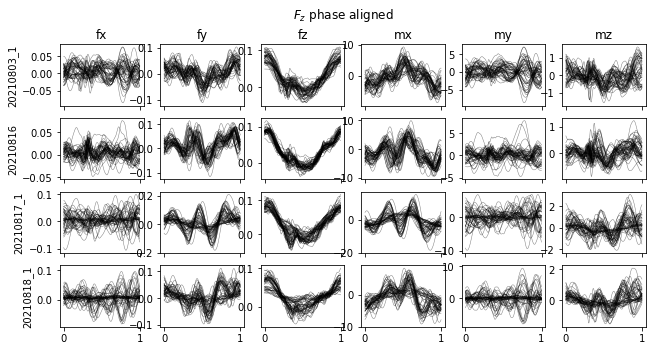

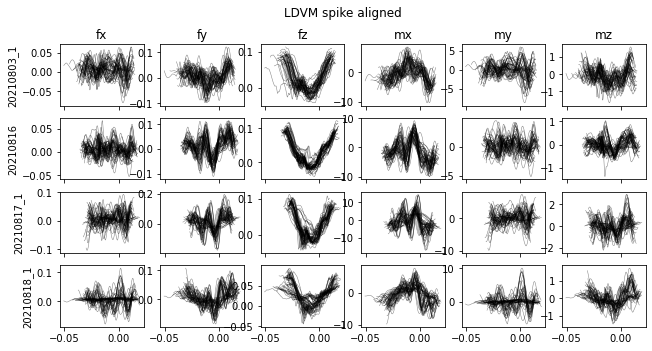

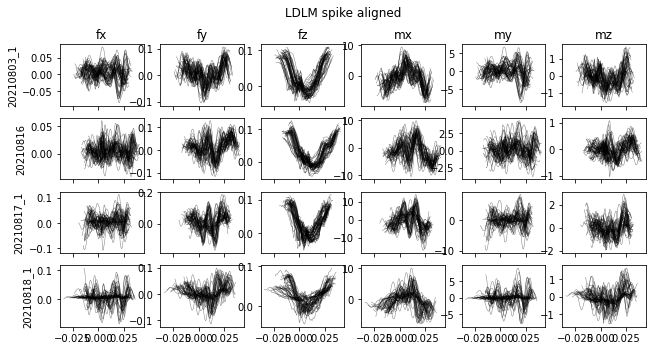

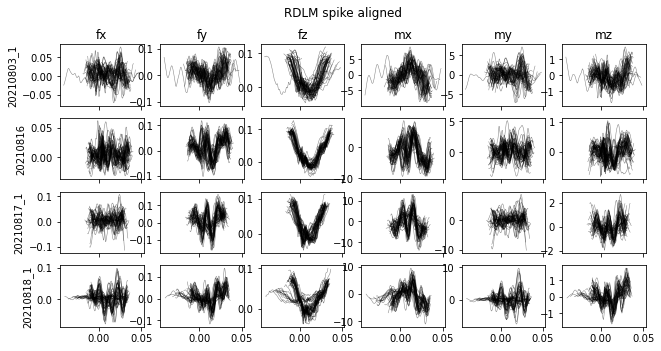

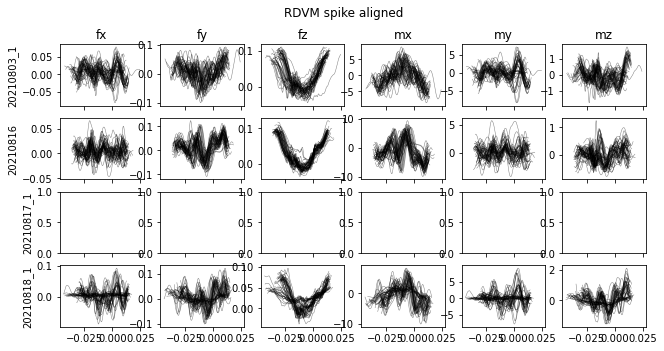

In [56]:
nwb = 50 # How many wingbeats to sample

#--- Fz phase aligned
fig, ax = plt.subplots(len(runDates), len(channelsFT), figsize=(10.5,5.2), sharex=True)
for i,d in enumerate(runDates):
    # grab this date
    dt = df.loc[(df.date==d) & (df.wb<-1),].copy()
    # Index the groups, select random subset
    g = dt.groupby(['pulse','wb'])
    a = np.arange(g.ngroups)
    np.random.shuffle(a)
    dt = dt[g.ngroup().isin(a[:nwb])]
    # Loop over randomly chosen groups and plotting variables, and plot
    for name, group in dt.groupby(['pulse','wb']):
        for j,m in enumerate(channelsFT):
            ax[i,j].plot(group.phase, group[m],
                         lw=0.5, alpha=0.5, color='black')
fig.suptitle(r'$F_z$ phase aligned')
for i,m in enumerate(channelsFT):
    ax[0,i].set_title(m)
for i,d in enumerate(runDates):
    ax[i,0].set_ylabel(d)

#--- First spike aligned
for alignMuscle in channelsEMG:
    fig, ax = plt.subplots(len(runDates), len(channelsFT), figsize=(10.5,5.2), sharex=True)
    for i,d in enumerate(runDates):
        # Grab data
        dt = df.loc[(df.date==d) & (df.wb<-1) & (~np.isnan(df[alignMuscle+'_fs']))].copy()
        # Continue only if aligning muscle had data 
        if len(dt)!=0:
            # Index the groups, select random subset
            g = dt.groupby(['pulse','wb'])
            a = np.arange(g.ngroups)
            np.random.shuffle(a)
            dt = dt[g.ngroup().isin(a[:nwb])]
            # Loop over randomly chosen groups and plotting variables, and plot
            for name, group in dt.groupby(['pulse','wb']):
                for j,m in enumerate(channelsFT):
                    ax[i,j].plot(group.Time-group.Time.iloc[int(group[alignMuscle+'_fs'].iloc[0])],
                                group[m],
                                lw=0.5, alpha=0.5, color='black')
    fig.suptitle(alignMuscle+' spike aligned')
    for i,m in enumerate(channelsFT):
        ax[0,i].set_title(m)
    for i,d in enumerate(runDates):
        ax[i,0].set_ylabel(d)


# Top-down contour plots of torque traces separated by some variable
General method for taking a start point (spike triggered, stim triggered, wingbeat, etc), a separating variable (like mean torque, or induced spike time difference), and plotting torque traces over time in 3D represenation

In [185]:
from scipy.interpolate import griddata
startinwb = -1
uselen = 100 #ms
gridlen = 1000

# Figure setup
fig = plt.figure()
# ax = plt.axes(projection='3d')

# make dataframe subset
dt = df.loc[(df.wb>=startinwb) & (df.stimphase<0.5)].copy()
dt = dt.loc[dt.date=='20210818_1']
dt['tdl'] = (dt['LDVM_fs']-dt['LDLM_fs'])/10
dt['tdr'] = (dt['RDVM_fs']-dt['RDLM_fs'])/10
dt.loc[(dt['tdl']<0) | (dt['tdr']<0), ['tdl','tdr']] = np.nan

# Color setup
viridis = cmx.get_cmap('viridis')
maxcol, mincol = np.max(dt['tdl']), np.min(dt['tdl'])

# Zero time
dt.Time = dt.groupby(['date','pulse'], group_keys=False).apply(
    lambda g: g['Time'] - g.loc[(g.wb==0), 'Time'].iloc[0]
)
dt = dt.loc[(dt.Time>=0) & (dt.Time<uselen/1000)]

ngroup, groupsize = dt.groupby(['date','pulse']).ngroups, uselen*10+1
mat = np.zeros((3,ngroup*groupsize))
i = 0
for name, g in dt.groupby(['date','pulse']):
    thiscol = g.loc[g.wbstate=='stim', 'tdl'].iloc[0]
    glen = len(g.Time)
    mat[0,i:i+glen] = g.Time # X
    mat[1,i:i+glen] = thiscol # Y
    mat[2,i:i+glen] = g.RDLM # Z
    i += glen
    # ax.plot3D(g.Time, thiscol*np.ones(len(g.Time)), g.RDLM,
    #           lw=0.5, alpha=0.6,
    #           color=viridis((maxcol-thiscol)/(maxcol-mincol)))
# Trim excess length, nan points
excess = np.argmin(np.flip(mat[0,:]==0))
mat = mat[:,0:-excess]
mat = mat[:, ~np.isnan(mat).any(axis=0)]

# Make grid to draw image on
gridx, gridy = np.mgrid[np.min(mat[0,:]):np.max(mat[0,:]):1000j, \
                        np.min(mat[1,:]):np.max(mat[1,:]):1000j]

gridz = griddata(mat[0:2,:].T, mat[2,:], (gridx,gridy), method='cubic')
plt.imshow(gridz.T, origin='lower')